# **Домашнее задание 4: Анализ набора данных Echocardiogram**

### **ФИО: Исоев И.Н.**

### **1. Загрузка данных** 

In [1]:
# Загрузка данных и добавление названий столбцов
import pandas as pd
import numpy as np

df = pd.read_csv("echocardiogram.data", sep=",", header=None, na_values="?", on_bad_lines="skip")

columns = ["survival", "still-alive", "age-at-heart-attack", "pericardial-effusion",
           "partial-shortening", "epss", "lvdd", "wall-motion-score", "wall-motion-index",
           "mult", "name", "group", "alive-at"]

df.columns = columns

df.head()


,survival,still-alive,age-at-heart-attack,pericardial-effusion,partial-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,1.000,name,1.0,0.0
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.588,name,1.0,0.0
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,1.000,name,1.0,0.0
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.788,name,1.0,0.0
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.571,name,1.0,0.0


### **2. Обработка меток классов** 

In [3]:
# Проверка количества пропущенных значений
print(df["still-alive"].isnull().sum())

0


In [5]:
# Проверка количества классов
print(df["still-alive"].value_counts())

still-alive
0    88
1    43
Name: count, dtype: int64


### **3. Предобработка признаков** 

In [7]:
# Проверяем типы данных
print(df.dtypes)

survival                float64
still-alive               int64
age-at-heart-attack     float64
pericardial-effusion      int64
partial-shortening      float64
epss                    float64
lvdd                    float64
wall-motion-score       float64
wall-motion-index       float64
mult                    float64
name                     object
group                   float64
alive-at                float64
dtype: object


In [9]:
# Преобразуем числовые признаки, если они были распознаны неправильно
for col in df.columns:
    if df[col].dtype == "object":
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            print(f"Не удалось преобразовать {col}, возможно, это категориальный признак.")


Не удалось преобразовать name, возможно, это категориальный признак.


In [11]:
# Удаляем категориальные признаки (текстовые значения)
df = df.select_dtypes(include=[np.number])

In [13]:
# Заполняем пропущенные значения средними отдельно для классов 0 и 1
df_alive = df[df["still-alive"] == 1]
df_dead = df[df["still-alive"] == 0]

for col in df.columns:
    if col != "still-alive": 
        df.loc[df["still-alive"] == 1, col] = df_alive[col].fillna(df_alive[col].mean())
        df.loc[df["still-alive"] == 0, col] = df_dead[col].fillna(df_dead[col].mean())

print(df.isnull().sum())

survival                0
still-alive             0
age-at-heart-attack     0
pericardial-effusion    0
partial-shortening      0
epss                    0
lvdd                    0
wall-motion-score       0
wall-motion-index       0
mult                    0
group                   0
alive-at                0
dtype: int64


### **4. Отбор признаков** 

In [36]:
# Определяем топ три наиболее значимых признака
unique_counts = df.nunique()

numeric_features = unique_counts[unique_counts > 10].index.tolist()

correlations = df[numeric_features].corrwith(df["still-alive"]).abs()

top_features = correlations.sort_values(ascending=False).head(10)

print("Топ-3 наиболее значимых признака:")

print(top_features)


Топ-3 наиболее значимых признака:
survival               0.713856
wall-motion-index      0.389324
epss                   0.350656
partial-shortening     0.304556
age-at-heart-attack    0.301857
lvdd                   0.281588
wall-motion-score      0.276787
mult                   0.142175
dtype: float64


### **5. Визуализация данных** 

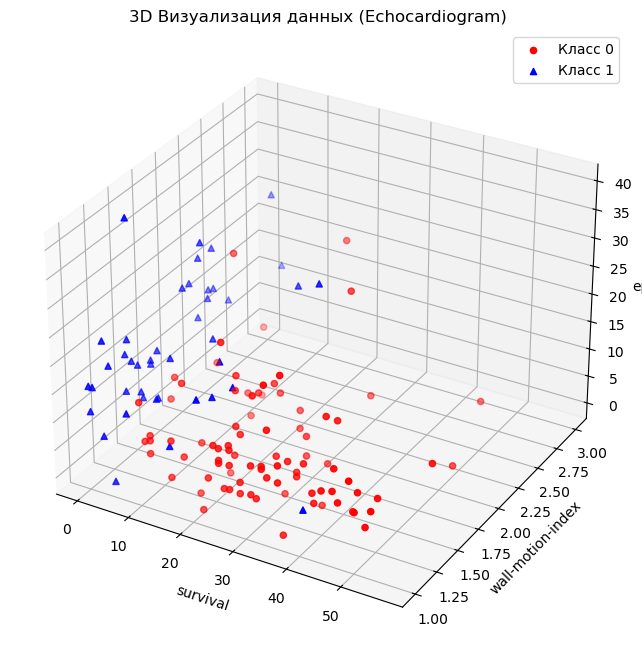

In [17]:
# Построем 3D-график точек данных
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

feature1, feature2, feature3 = top_features.index

class_0 = df[df["still-alive"] == 0]
class_1 = df[df["still-alive"] == 1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(class_0[feature1], class_0[feature2], class_0[feature3], 
           c="red", marker="o", label="Класс 0")
ax.scatter(class_1[feature1], class_1[feature2], class_1[feature3], 
           c="blue", marker="^", label="Класс 1")

ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_zlabel(feature3)

ax.set_title("3D Визуализация данных (Echocardiogram)")

ax.legend()
plt.show()


### **6. Классификация** 

In [21]:
# Разделение данных и стандартизация признаков
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

feature1, feature2 = top_features.index[:2]  
X = df[[feature1, feature2]]  
y = df["still-alive"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
# Обучение модели классификатора ближайших соседей (KNN, k=3)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"Точность KNN (k=3): {acc_knn:.4f}")


Точность KNN (k=3): 0.8000


In [25]:
# Обучение модели логистической регрессии (итерации: 565)
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=565)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

print(f"Точность Логистической Регрессии: {acc_lr:.4f}")


Точность Логистической Регрессии: 0.9000


In [27]:
# Обучение модели дерева решений (max_depth=5)
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"Точность Дерева Решений (max_depth=5): {acc_dt:.4f}")


Точность Дерева Решений (max_depth=5): 0.9000


### **7. Визуализация границ решений**

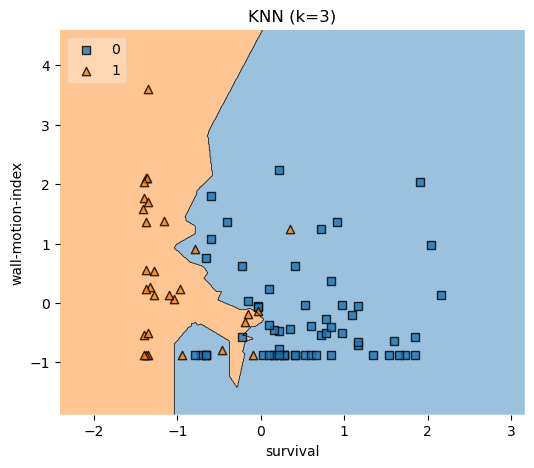

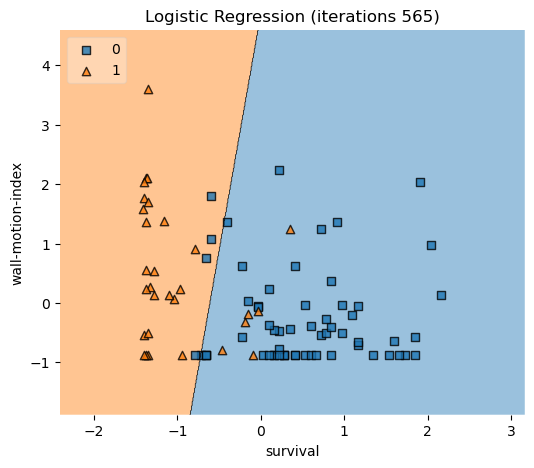

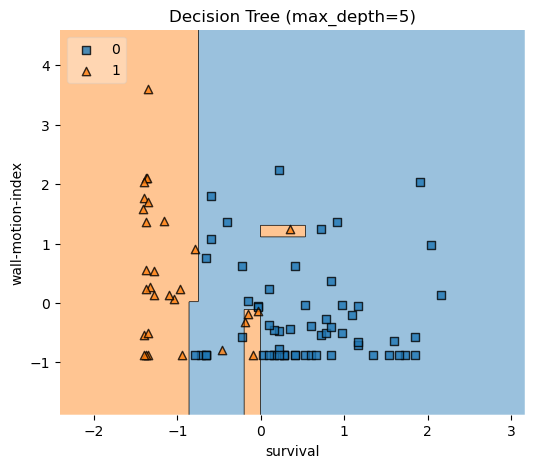

In [29]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

def plot_decision_boundary(model, X, y, title):
    plt.figure(figsize=(6, 5))
    plot_decision_regions(X, y.to_numpy(), clf=model, legend=2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()

# Границы для KNN
plot_decision_boundary(knn, X_train, y_train, "KNN (k=3)")

# Границы для Логистической Регрессии
plot_decision_boundary(lr, X_train, y_train, "Logistic Regression (iterations 565)")

# Границы для Дерева Решений
plot_decision_boundary(dt, X_train, y_train, "Decision Tree (max_depth=5)")


### **8. ROC-кривые**

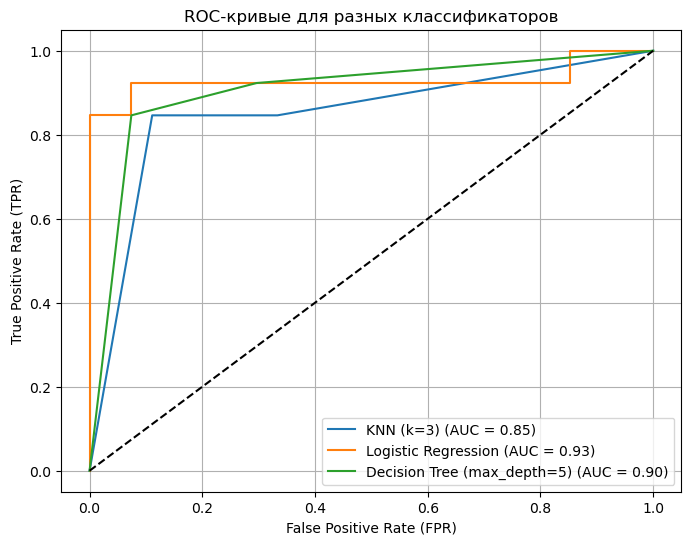

In [31]:
#ROC-кривые для разных классификаторов
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC-кривые для разных классификаторов")
    plt.legend()
    plt.grid()
    plt.show()

models = {
    "KNN (k=3)": knn,
    "Logistic Regression": lr,
    "Decision Tree (max_depth=5)": dt
}

plot_roc_curve(models, X_test, y_test)


### **9. Оценка качества классификации**

In [33]:
#Определим лучший метод классификации по показателю площади под ROC-кривой (AUC)
from sklearn.metrics import roc_auc_score

def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_train_scores = model.predict_proba(X_train)[:, 1]
            y_test_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_train_scores = model.decision_function(X_train)
            y_test_scores = model.decision_function(X_test)

        auc_train = roc_auc_score(y_train, y_train_scores)
        auc_test = roc_auc_score(y_test, y_test_scores)

        results.append((name, auc_train, auc_test))

    return results

results = evaluate_models(models, X_train, y_train, X_test, y_test)

print("🔹 AUC на train и test:")
print("-----------------------------------------------------")
print(f"{'Модель':<30}{'AUC Train':<15}{'AUC Test'}")
print("-----------------------------------------------------")
for name, auc_train, auc_test in results:
    print(f"{name:<30}{auc_train:<15.3f}{auc_test:.3f}")

best_model = max(results, key=lambda x: x[2])
print("\n🏆 Лучшая модель по AUC (test):", best_model[0])


🔹 AUC на train и test:
-----------------------------------------------------
Модель                        AUC Train      AUC Test
-----------------------------------------------------
KNN (k=3)                     0.984          0.850
Logistic Regression           0.956          0.929
Decision Tree (max_depth=5)   0.999          0.905

🏆 Лучшая модель по AUC (test): Logistic Regression


#### **Общий вывод:**

Исходя из значений **AUC** на обучающей и тестовой выборках для каждой модели, можно сделать следующие выводы о **переобучении (overfitting)** и **недообучении (underfitting)**:

- Модель **KNN** и **Дерево решений** имеют явные признаки **переобучения**, так как они показывают слишком высокие результаты на обучающих данных и значительное снижение производительности на тестовых.
  
- **Логистическая регрессия** показала **хорошие результаты** и, скорее всего, не переобучена и не недообучена. Модель ведет себя вполне адекватно, дополнительные шаги не требуются.

Для моделей с переобучением стоит попробовать **регуляризацию**, **параметрическую настройку** (например, увеличить k в KNN или уменьшить max_depth в дереве решений), а также применить другие методы для улучшения обобщающей способности.